### **TRIỂN KHAI MÔI TRƯỜNG**

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import pickle
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, precision_score
from sklearn.metrics import average_precision_score, accuracy_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

import nltk
from nltk import classify
from nltk.tokenize import word_tokenize
from nltk.probability import LaplaceProbDist
from nltk.classify import NaiveBayesClassifier, MaxentClassifier

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dangnhathuy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
path = 'https://raw.githubusercontent.com/dangdailoi/NLP/main/Ratings.csv'

df = pd.read_csv(path)

### **Processing**

In [5]:
# Assuming df is your DataFrame with 'review' and 'label' columns
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [6]:
# Train data
train_data = []
for index, row in enumerate(X_train):
    words = word_tokenize(row)
    words = [word.lower() for word in words if word.isalpha()]
    features = dict([(word, True) for word in words])
    train_data.append((features, y_train.iloc[index]))

In [7]:
# Evaluate on the test set
true_labels = []
test_data = []

for text, label in zip(X_test, y_test):  # Assuming y_test contains labels
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    features = dict([(word, True) for word in words])
    test_data.append((features, label))
    true_labels.append(label)

### **NaiveBayesClassifier**

In [8]:
classifier_nb = NaiveBayesClassifier.train(train_data, estimator = LaplaceProbDist)

In [9]:
# Save the NaiveBayesClassifier model
with open('./model/model_naivebayes.pickle', 'wb') as model_file:
    pickle.dump(classifier_nb, model_file)

### **MaxentClassifier**

In [10]:
classifier_mx = MaxentClassifier.train(train_data, algorithm='iis', max_iter=10)

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.808
             2          -0.26253        0.892
             3          -0.21203        0.909
             4          -0.19822        0.913
             5          -0.19097        0.915
             6          -0.18581        0.917
             7          -0.18174        0.919
             8          -0.17836        0.920
             9          -0.17549        0.920
         Final          -0.17299        0.921


In [11]:
# Save the MaxentClassifier model
with open('./model/model_maxent.pickle', 'wb') as model_file:
    pickle.dump(classifier_mx, model_file)

### **LSTM**

In [33]:
# Tokenize the text
max_words = 1000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(df['review'].values)
X = tokenizer.texts_to_sequences(df['review'].values)
X = pad_sequences(X)
y = df['label']

In [34]:
# Split the data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Build the LSTM model
embedding_dim = 128
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, embedding_dim, input_length=X.shape[1]))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
# Train the model
batch_size = 32
epochs = 5
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/5
2020/2020 [==============================] - 223s 110ms/step - loss: 0.2699 - accuracy: 0.8988 - val_loss: 0.2412 - val_accuracy: 0.9132
Epoch 2/5
2020/2020 [==============================] - 227s 113ms/step - loss: 0.2351 - accuracy: 0.9141 - val_loss: 0.2337 - val_accuracy: 0.9158
Epoch 3/5
2020/2020 [==============================] - 218s 108ms/step - loss: 0.2257 - accuracy: 0.9181 - val_loss: 0.2287 - val_accuracy: 0.9166
Epoch 4/5
2020/2020 [==============================] - 217s 107ms/step - loss: 0.2190 - accuracy: 0.9204 - val_loss: 0.2291 - val_accuracy: 0.9167
Epoch 5/5
2020/2020 [==============================] - 222s 110ms/step - loss: 0.2142 - accuracy: 0.9218 - val_loss: 0.2292 - val_accuracy: 0.9171


In [37]:
# Save the LSTM model
lstm_model.save('./model/model_lstm.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Fuction Evaluate**

In [38]:
def compare_models_performance(model_names, models, test_data_list, true_labels_list):
    results = []

    for name, model, test_data, true_labels in zip(model_names, models, test_data_list, true_labels_list):
        if name == 'LSTM':
            predictions = (model.predict(test_data) > 0.5).astype(int).flatten()
        else:
            predictions = [model.classify(features) for features, _ in test_data]

        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        auc = roc_auc_score(true_labels, predictions)

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
        })

    df = pd.DataFrame(results)
    df_styled = df.style.applymap(lambda x: f'background-color: {x}', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
    df_styled = df_styled.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
    return df_styled

In [39]:
def plot_precision_recall_curves(model_names, models, test_data_list, true_labels_list):
    plt.figure(figsize=(8, 6))

    for model, test_data, label, true_labels in zip(models, test_data_list, model_names, true_labels_list):
        if 'LSTM' in label:
            probs = model.predict(test_data)
        else:
            probs = [model.prob_classify(features).prob(1) for features, _ in test_data]

        precision, recall, _ = precision_recall_curve(true_labels, probs)
        pr_auc = average_precision_score(true_labels, probs)

        # Plot precision-recall curve for the model
        plt.plot(recall, precision, lw=2, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.show()

In [40]:
def plot_roc_curves(model_names, models, test_data_list, true_labels_list):
    plt.figure(figsize=(8, 6))

    for model, test_data, label, true_labels in zip(models, test_data_list, model_names, true_labels_list):
        # Check if the model is Naive Bayes or LSTM
        if 'LSTM' in label:
            # For LSTM, use the model.predict instead of model.predict_proba
            probs = model.predict(test_data)[:, 0]  # Assuming you want the probability of the positive class
        else:
            # For Naive Bayes or other models, use the existing approach
            probs = [model.prob_classify(features).prob(1) for features, _ in test_data]

        fpr, tpr, _ = roc_curve(true_labels, probs)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for the model
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

### **Evaluation**

In [41]:
with open('./model/model_naivebayes.pickle', 'rb') as model_file:
    classifier_nb = pickle.load(model_file)

with open('./model/model_maxent.pickle', 'rb') as model_file:
    classifier_mx= pickle.load(model_file)

model_lstm = load_model('./model/model_lstm.h5')

model_names = ['Naive Bayes', 'MEMM', 'LSTM']
models = [classifier_nb, classifier_mx, model_lstm]
test_data_list = [test_data, test_data, X_test_lstm]
true_labels_list = [true_labels, true_labels, y_test_lstm]

In [42]:
compare_models_performance(model_names, models, test_data_list, true_labels_list)

505/505 [==============================] - 11s 22ms/step


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Naive Bayes,0.905360,0.923447,0.961939,0.942300,0.818080
1,MEMM,0.917121,0.934653,0.964250,0.949221,0.844416
2,LSTM,0.917059,0.931938,0.967409,0.949342,0.839386


505/505 [==============================] - 11s 23ms/step


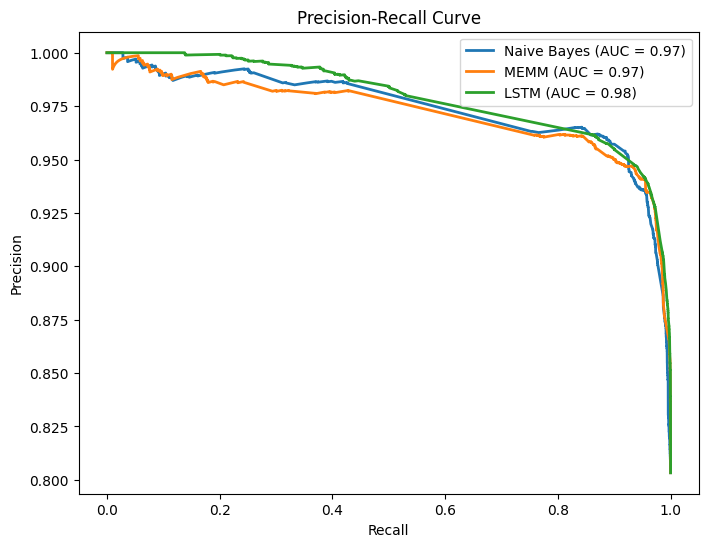

In [43]:
plot_precision_recall_curves(model_names, models, test_data_list, true_labels_list)

505/505 [==============================] - 11s 22ms/step


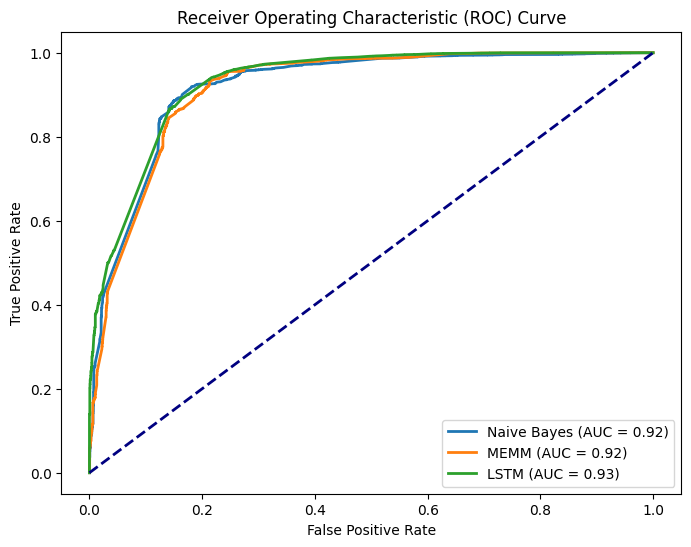

In [44]:
plot_roc_curves(model_names, models, test_data_list, true_labels_list)